# Requirements

In [192]:
import math

import pandas as pd
import numpy as np
import requests
import nltk

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD 
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# Read data

In [3]:
# LAGT (v1.0.1) dataset directly from Zenodo
resp = requests.get("https://zenodo.org/record/4971946/files/LAGT_v1-0.json?download=1")
LAGT = pd.DataFrame(resp.json())

In [70]:
LAGT["lemmata"] = LAGT["lemmatized_sentences"].apply(lambda x: [item for sublist in x for item in sublist])

In [4]:
%%bash
curl https://raw.githubusercontent.com/kasev/paul/master/data/LAGT_metadata.csv -o ../data/LAGT_metadata.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  241k  100  241k    0     0  2152k      0 --:--:-- --:--:-- --:--:-- 2152k


In [5]:
LAGT_metadata = pd.read_csv("../data/LAGT_metadata.csv")
provenience_dict = dict(zip(LAGT_metadata["filename"],  LAGT_metadata["provenience"]))
author_dict = dict(zip(LAGT_metadata["author_id"],  LAGT_metadata["author"]))
LAGT["provenience"] = LAGT["filename"].apply(lambda x: provenience_dict[x])

<AxesSubplot:xlabel='date_avr'>

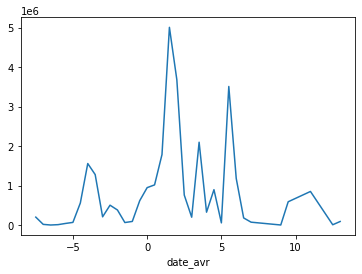

In [7]:
LAGT.groupby("date_avr").sum()["wordcount"].plot()

In [61]:

# function to extract all texts into one list of sentences
def get_flat_sentences(series):
    sentences_list = [sent for doc in series.tolist() for sent in doc]
    return sentences_list

In [71]:
sub_arc = LAGT[LAGT["date_avr"] < -5]
sub_cla = LAGT[LAGT["date_avr"].between(-5, -3.5)]
sub_hel = LAGT[LAGT["date_avr"].between(-3, -0.5)]
sub_rom = LAGT[(LAGT["date_avr"].between(0, 4.5)) & (LAGT["provenience"]=="pagan")]
sub_chr = LAGT[(LAGT["provenience"]=="christian") & (LAGT["date_avr"]<5)]
sub_jew = LAGT[(LAGT["provenience"]=="jewish") & (LAGT["date_avr"]<5)]
corpora_dfs = [sub_arc, sub_cla, sub_hel, sub_rom, sub_chr, sub_jew]
corpora_labels = ["Archaic", "Classical", "Hellenistic", "Christian", "Jewish"]

In [72]:
corpora = []
for corp_df, label in zip(corpora_dfs, corpora_labels):
    corpus = {}
    corpus["label"] = label
    corpus["n_authors"] = len(list(corp_df["author_id"].unique()))
    corpus["n_works"] = len(corp_df)
    corpus["n_sentences"] = corp_df["n_sentences"].sum()
    corpus["wordcount"] = corp_df["wordcount"].sum()
    corpus["sentences"] = get_flat_sentences(corp_df["lemmatized_sentences"])
    corpus["lemmata"] = [item for sublist in corp_df["lemmata"].tolist() for item in sublist] 
    corpora.append(corpus)

In [73]:
pd.DataFrame(corpora)

,label,n_authors,n_works,n_sentences,wordcount,sentences,lemmata
0,Archaic,8,12,20502,265138,"[[μῆνις, ἀείδω, θεά, Πηλείδης, Ἀχιλλεύς, οὐλόμ...","[μῆνις, ἀείδω, θεά, Πηλείδης, Ἀχιλλεύς, οὐλόμε..."
1,Classical,36,367,256084,3460971,"[[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελ...","[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελο..."
2,Hellenistic,34,96,154615,1860841,"[[ἄρχω, Φοῖβος, παλαιγενής, κλέος, φώς, μιμνήσ...","[ἄρχω, Φοῖβος, παλαιγενής, κλέος, φώς, μιμνήσκ..."
3,Christian,97,609,1014984,11981922,"[[φιλοσοφία, ἔργον, ἔνιοι, φημί, βάρβαρος, ἄρχ...","[φιλοσοφία, ἔργον, ἔνιοι, φημί, βάρβαρος, ἄρχω..."
4,Jewish,49,148,343318,3566823,"[[βίβλος, γένεσις, Ἰησοῦς, Χριστός, υἱός, Δαυί...","[βίβλος, γένεσις, Ἰησοῦς, Χριστός, υἱός, Δαυίδ..."


# Embeddings - preprocessing

In [290]:
sentences = corpora[0]["sentences"]
min_freq = 5

def get_vocab(docs, min_freq=5):
    words_flat = [item for sublist in docs for item in sublist] 
    word_freq_tups = nltk.FreqDist(words_flat).most_common()
    vocabulary = [tup[0] for tup in word_freq_tups if tup[1] >= min_freq]
    #vocab_freqs = [len([doc for doc in docs if word in doc]) for word in vocabulary]
    return words_flat, vocabulary # , vocab_freqs

In [291]:
words_flat, vocabulary = get_vocab(sentences)

In [292]:
len(set(corpora[0]["lemmata"]))

15329

In [293]:
len(list(set(corpora[0]["lemmata"]) & set(corpora[1]["lemmata"])))

8760

In [294]:
vocabs_list = []
for corp in corpora:
    if corp["label"] not in ["christian", "jewish"]:
        vocabs_list.append(get_vocab(corp["sentences"])[1])

In [295]:
vocab_intersect = list(set.intersection(*map(set,vocabs_list)))
len(vocab_intersect)

2134

In [431]:
def get_cooc(docs, vocabulary=None, min_freq=5):
    if vocabulary==None:
        lemmata, vocabulary = get_vocab(docs, min_freq)
    vec_bow = CountVectorizer(vocabulary=vocabulary, lowercase=False) 
    bow = vec_bow.fit_transform([" ".join(list(set(sentence))) for sentence in docs])
    cooc  = bow.T * bow
    #cooc = cooc / len(docs)
    return cooc, vocabulary

In [432]:
small_voc = ['εἰμί', 'αὐτός', 'πᾶς', 'ἀνήρ', 'πολύς', 'φημί', 'ἔχω', 'θεός', 'Ζεύς', 'μέγας']

In [444]:
cooc, vocab = get_cooc(sentences, vocabulary=small_voc, min_freq=5)

In [445]:
cooc.todense()

matrix([[2367,  191,  194,  219,  205,   97,   99,  208,  132,  138],
        [ 191, 1526,  113,   83,  101,   75,   99,   87,   76,   75],
        [ 194,  113, 1341,   89,   64,   80,   87,  141,   82,   66],
        [ 219,   83,   89, 1226,  142,   53,   85,  122,   75,   82],
        [ 205,  101,   64,  142, 1117,   34,   63,   53,   63,   67],
        [  97,   75,   80,   53,   34, 1129,   36,   40,   38,   36],
        [  99,   99,   87,   85,   63,   36, 1037,   95,   46,   56],
        [ 208,   87,  141,  122,   53,   40,   95,  997,  124,   78],
        [ 132,   76,   82,   75,   63,   38,   46,  124,  957,   96],
        [ 138,   75,   66,   82,   67,   36,   56,   78,   96,  945]])

In [435]:
## PPMI3 calculation example
191 ** 3 / (2551 * 1588)

1.7200423699107477

In [447]:
cooc, vocabulary = get_cooc(corpora[0]["sentences"], vocabulary=vocab_intersect)
cooc.todense()

matrix([[142,   0,   0, ...,   0,   0,   0],
        [  0,  26,   0, ...,   0,   0,   0],
        [  0,   0,   8, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,  12,   0,   0],
        [  0,   0,   0, ...,   0,  50,   0],
        [  0,   0,   0, ...,   0,   0,  64]])

In [448]:
cooc.todense().shape

(2134, 2134)

In [449]:
len(vocabulary)

2134

In [450]:
np.log2(np.array([10, 9, 8, 7]))

array([3.32192809, 3.169925  , 3.        , 2.80735492])

In [451]:
# deal with division by zero
ab_3 = np.array([2, 0, 5, 0], dtype=float)
axb = np.array([2, 0, 5, 1], dtype=float)

np.divide(ab_3, axb, out=np.zeros_like(ab_3), where=axb!=0)

array([1., 0., 1., 0.])

In [452]:
def normalize_ppmi3_matrix(pmi_matrix_df):
    minval, maxval = pmi_matrix_df.min().min(), pmi_matrix_df.max().max()
    minval_2 = minval * 2
    pmi_matrix_df.fillna(minval_2, inplace=True)
    pmi_matrix_norm_df = (pmi_matrix_df - minval_2) / (maxval - minval_2)
    return pmi_matrix_norm_df

In [453]:
def get_ppmi3_df(cooc, vocabulary, normalize=True):
    pmi_rows_list = []
    for i in range(cooc.shape[1]):
        ab_3 = np.array([row_el ** 3 for row_el in list(cooc[i].toarray()[0])], dtype=float)
        axb = np.array([cooc[row_el[0], row_el[0]] * cooc[i, i] for row_el in enumerate(list(cooc[i].toarray()[0]))], dtype=float)
        pmi_row = np.divide(ab_3, axb, out=np.zeros_like(ab_3), where=axb!=0)
        pmi_rows_list.append(pmi_row)
    pmi_matrix_df = pd.DataFrame(pmi_rows_list, columns=vocabulary, index=vocabulary)
    if normalize==True:
        pmi_matrix_df = normalize_ppmi3_matrix(pmi_matrix_df)
    return pmi_matrix_df #pmi_matrix_norm_df

data = get_ppmi3_df(cooc, vocabulary, normalize=True)
pd.DataFrame(data)

In [430]:
np.log2(data)

,εἰμί,αὐτός,πᾶς,ἀνήρ,πολύς,φημί,ἔχω,θεός,Ζεύς,μέγας
εἰμί,-3.114633,-13.375574,-13.121676,-12.467703,-12.619294,-15.873412,-15.662451,-12.392452,-14.301514,-14.090918
αὐτός,-13.375574,-3.747938,-14.827573,-16.033641,-15.049795,-16.353390,-15.029147,-15.531635,-16.057609,-16.096731
πᾶς,-13.121676,-14.827573,-3.934384,-15.545114,-16.837984,-15.887616,-15.401940,-13.255366,-15.542290,-16.463559
ἀνήρ,-12.467703,-16.033641,-15.545114,-4.063734,-13.259392,-17.540289,-15.373248,-13.752458,-15.799139,-15.394735
πολύς,-12.619294,-15.049795,-16.837984,-13.259392,-4.198064,-19.327332,-16.535251,-17.226579,-16.419426,-16.134793
φημί,-15.873412,-16.353390,-15.887616,-17.540289,-19.327332,-4.182647,-18.972732,-18.459972,-18.622899,-18.838702
ἔχω,-15.662451,-15.029147,-15.401940,-15.373248,-16.535251,-18.972732,-4.305277,-14.593560,-17.673366,-16.803783
θεός,-12.392452,-15.531635,-13.255366,-13.752458,-17.226579,-18.459972,-14.593560,-4.362027,-13.324713,-15.312891
Ζεύς,-14.301514,-16.057609,-15.542290,-15.799139,-16.419426,-18.622899,-17.673366,-13.324713,-4.421102,-14.355135
μέγας,-14.090918,-16.096731,-16.463559,-15.394735,-16.134793,-18.838702,-16.803783,-15.312891,-14.355135,-4.439307


In [421]:
data = get_ppmi3_df(cooc, vocabulary)

/tmp/ipykernel_6522/1405777701.py:6: RuntimeWarning: divide by zero encountered in log2
  pmi_row = np.log2(np.divide(ab_3, axb, out=np.zeros_like(ab_3), where=axb!=0))


In [422]:
pd.DataFrame(data)

,ἴσος,ἄγαμαι,πηδάλιον,ἰός,ἐπίσταμαι,χρίω,ψυχή,μάγειρος,πιστεύω,πλῆθος,...,αἰτία,εὔκαιρος,σταθμόν,μικρός,τετράς,ἀποκρύπτω,σπόγγος,ἐπιλανθάνομαι,ἀνάγκη,ἀγείρω
ἴσος,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ἄγαμαι,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
πηδάλιον,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ἰός,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ἐπίσταμαι,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ἀποκρύπτω,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
σπόγγος,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ἐπιλανθάνομαι,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ἀνάγκη,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [354]:
def get_ppmi3_df(cooc, vocabulary):
    pmi_rows_list = []
    for i in range(cooc.shape[1]):
        
        pmi_rows_list.append([math.log(row_el[1] ** 3 / (cooc[row_el[0], row_el[0]] * cooc[i, i])) for row_el in enumerate(list(cooc[i].data))])
        #pmi_rows_list.append([math.log(row_el[1] ** 3 / (cooc[row_el[0], row_el[0]] * cooc[i, i])) if (cooc[row_el[0], row_el[0]] * cooc[i, i]) > 0 else None for row_el in enumerate(list(cooc[i].data))])
    pmi_matrix_df = pd.DataFrame(pmi_rows_list, columns=vocabulary, index=vocabulary)
    minval, maxval = pmi_matrix_df.min().min(), pmi_matrix_df.max().max()
    minval_2 = minval * 2
    pmi_matrix_df.fillna(minval_2, inplace=True)
    pmi_matrix_norm_df = (pmi_matrix_df - minval_2) / (maxval - minval_2)
    return pmi_matrix_norm_df

In [348]:
def svd_reduction(cooc_matrix, n_components=300, random_state=1, n_iter=100):
    svd = TruncatedSVD(n_components=n_components, random_state=random_state, n_iter=n_iter)
    svd_matrix = svd.fit_transform(cooc_matrix)
    return svd_matrix

In [336]:
def from_docs_to_vectors(docs, vocabulary=None, min_freq=5):
    cooc, vocabulary = get_cooc(docs, vocabulary=vocabulary, min_freq=min_freq)
    pmi_matrix = get_ppmi3_df(cooc, vocabulary)
    word_vectors_array = svd_reduction(pmi_matrix, n_components=300, random_state=1, n_iter=100)
    word_vectors_df = pd.DataFrame(word_vectors_array, index=vocabulary)
    return word_vectors_df

In [350]:
df = get_ppmi3_df(cooc, vocabulary)
df.head(5)

ValueError: 2134 columns passed, passed data had 2078 columns

In [338]:
%%time
word_vectors_arc = from_docs_to_vectors(corpora[0]["sentences"], vocabulary=vocab_intersect)
word_vectors_cla = from_docs_to_vectors(corpora[1]["sentences"], vocabulary=vocab_intersect)

/tmp/ipykernel_6522/3021146163.py:4: RuntimeWarning: divide by zero encountered in long_scalars
  pmi_rows_list.append([math.log(row_el[1] ** 3 / (cooc[row_el[0], row_el[0]] * cooc[i, i])) if row_el[1] > 0 else None for row_el in enumerate(list(cooc[i].data))])


ValueError: 2134 columns passed, passed data had 1724 columns

In [152]:
len(vocab_intersect)

2134

In [164]:
word_vectors_arc.shape

(2134, 250)

In [171]:
cosine_similarity((word_vectors_arc.loc["ἴσος"], word_vectors_cla.loc["ἴσος"]))[1,0]

0.6847738670651788

In [172]:
print("hello")

hello


In [173]:
sem_sim = []
for word in  vocab_intersect:
    sem_sim.append((word, cosine_similarity((word_vectors_arc.loc[word], word_vectors_cla.loc[word]))[1,0]))

In [178]:
sorted(sem_sim, key =lambda x: x[1])

[('Νηρεύς', -0.009428537231244321),
 ('περί-εἶμι', 0.0),
 ('ἀλέκτωρ', 0.018660607758614358),
 ('διηνεκής', 0.0371580946325353),
 ('κάμινος', 0.040839141150018486),
 ('δίω', 0.05158568138104155),
 ('προσποιέω', 0.05259036361656007),
 ('ἐρεύγομαι', 0.05363196430846095),
 ('λογίζομαι', 0.059042563014576985),
 ('ζηλόω', 0.0591684059574803),
 ('ἐαρινός', 0.06317736043369676),
 ('φάρυγξ', 0.07071232566068172),
 ('σκεδάννυμι', 0.07554619689441643),
 ('καταφρονέω', 0.0781163722547858),
 ('πρέσβις', 0.07907073406471542),
 ('σφυρόν', 0.08004766652734248),
 ('κῆτος', 0.08321913290970981),
 ('αὖος', 0.08685803434282735),
 ('ἄπυρος', 0.08720679279927651),
 ('φαέθω', 0.0907364994205931),
 ('ἔντερον', 0.0907834141928039),
 ('φρόνιμος', 0.09084089825182408),
 ('ἀποκρίνω', 0.09223659140617313),
 ('ψαύω', 0.0923736349533133),
 ('στάθμη', 0.09366781588922668),
 ('βόειος', 0.09381920010906637),
 ('ῥήτωρ', 0.09471658260198947),
 ('ἀγλαία', 0.09508637233155032),
 ('συντρίβω', 0.0964142954706375),
 ('αἰπεινό

In [ ]:
pmi_matrix["θεός"]

In [ ]:
pmi_matrix["Ζεύς"